In [1]:
# Step 1: Setup and Imports
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib
import PIL
from PIL import Image

2024-11-09 12:30:59.066756: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 12:30:59.101375: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 12:31:00.518236: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 12:31:00.711786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 12:31:01.279793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# Define image size and paths
img_height, img_width = 224, 224
batch_size = 32

# Step 2: Load Image from URL and Visualize
# Function to download the image from the URL
def download_image_from_url(url, save_path):
    urllib.request.urlretrieve(url, save_path)

In [3]:
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/vmox93cwsx2vzrish3l63/land_ls_model_data_four.zip?rlkey=6uykz7bb0aoqbl8hgfkpt1t4f&dl=0?raw=1"

# Download and unzip the dataset
dataset_path = tf.keras.utils.get_file('land_ls_model_data_four.zip', origin=dataset_url, extract=True)
extracted_dir = os.path.join(os.path.dirname(dataset_path), 'land_ls_model_data_four')  # Adjust path as necessary



In [4]:
import zipfile
extracted_dir = os.path.join(os.path.dirname(dataset_path), 'land_ls_model_data_four')
if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Extract the ZIP file
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Check if the extraction was successful
if not os.path.exists(extracted_dir):
    print(f"Extraction failed or directory does not exist: {extracted_dir}")
else:
    print(f"Dataset extracted successfully to: {extracted_dir}")

Dataset extracted successfully to: /home/mjp2da/.keras/datasets/land_ls_model_data_four


In [5]:
import shutil
extracted_dir = '/home/mjp2da/.keras/datasets/land_ls_model_data_four'

# Create a 'train' directory if it doesn't exist
train_dir = os.path.join(extracted_dir, 'train')
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# Move 'landslide' and 'non_landslide' directories into the 'train' folder
landslide_dir = os.path.join(extracted_dir, 'landslide')
non_landslide_dir = os.path.join(extracted_dir, 'non_landslide')

# Move the directories into the 'train' directory
shutil.move(landslide_dir, os.path.join(train_dir, 'landslide'))
shutil.move(non_landslide_dir, os.path.join(train_dir, 'non_landslide'))



Error: Destination path '/home/mjp2da/.keras/datasets/land_ls_model_data_four/train/landslide/landslide' already exists

In [6]:
# URLs for sample images
landslide_img_one_url = "https://dl.dropboxusercontent.com/scl/fi/viovy9pcma2y6hq58ntns/NASA_GoogE_14445.jpg?rlkey=ltitymrzuarrxxogge32c1kbi&dl=0?raw=1"
landslide_img_two_url = "https://dl.dropboxusercontent.com/scl/fi/7x41si7aih0bjh1py2phy/NASA_GoogE_14445_NonSlide.jpg?rlkey=3ll97pdrjwr9b10rcvineeynm&dl=0?raw=1"

In [7]:
# Download images
landslide_img_one_path = tf.keras.utils.get_file('NASA_GoogE_14445', origin=landslide_img_one_url)
landslide_img_two_path = tf.keras.utils.get_file('NASA_GoogE_14445_NonSlide', origin=landslide_img_two_url)

In [8]:
def resize_show(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Prediction helper function
def predict_landslide_image(image_path, model):
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = predictions[0][0]

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format("landslide" if score > 0.5 else "non-landslide", 100 * score if score > 0.5 else 100 * (1 - score))
    )

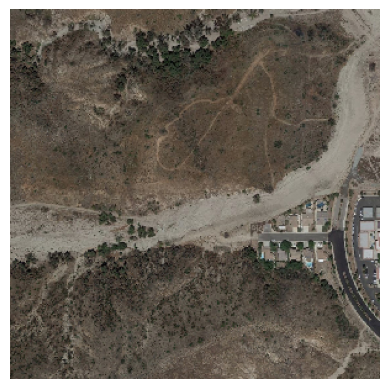

In [9]:
# Visualize images
PIL.Image.open(landslide_img_one_path)
resize_show(landslide_img_one_path)

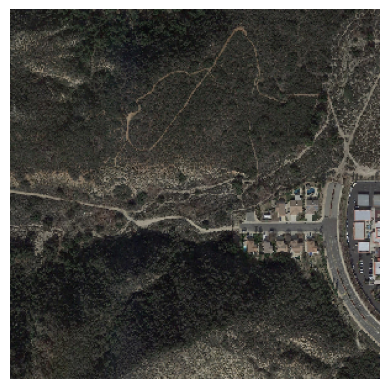

In [10]:
PIL.Image.open(landslide_img_two_path)
resize_show(landslide_img_two_path)

In [11]:
# Step 3: Model Setup

# Load DenseNet121 as base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base layers

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

2024-11-09 12:32:13.612852: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
# Create the final model
landslide_model_DenseNet = Model(inputs=base_model.input, outputs=output)

In [13]:
# Compile the model
landslide_model_DenseNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values between 0 and 1
    shear_range=0.2,              # Randomly shear images
    zoom_range=0.2,               # Randomly zoom images
    horizontal_flip=True,
    validation_split=0.2  # Randomly flip images horizontally
)

# Setup for training data - Assume that you have a directory with images classified into 'landslides' and 'non-landslides'
train_generator = train_datagen.flow_from_directory(
    train_dir,          # Path to your training data
    target_size=(img_height, img_width),  # Resize images to the required input size for DenseNet
    batch_size=batch_size,
    class_mode='binary'            # Binary classification: landslide vs non-landslide
)

Found 6400 images belonging to 2 classes.


In [15]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,                      # Path to your training data
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='binary',            # Binary classification: landslide vs non-landslide
    subset='validation'             # Specify subset for validation data
)

Found 1280 images belonging to 2 classes.


In [16]:
# Step 4: Train the Model
epochs = 10
history = landslide_model_DenseNet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10


/home/mjp2da/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 693s 3s/step - accuracy: 0.7883 - loss: 0.4216 - val_accuracy: 0.9180 - val_loss: 0.2108
Epoch 2/10


2024-11-09 12:44:05.246350: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-09 12:44:05.497461: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - accuracy: 0.9094 - loss: 0.2211 - val_accuracy: 0.9422 - val_loss: 0.1519
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10


2024-11-09 12:55:17.122144: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 668s 3s/step - accuracy: 0.9056 - loss: 0.2197 - val_accuracy: 0.9695 - val_loss: 0.1079
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step - accuracy: 0.9239 - loss: 0.1841 - val_accuracy: 0.9797 - val_loss: 0.0824
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10


2024-11-09 13:17:17.260515: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step - accuracy: 0.9320 - loss: 0.1666 - val_accuracy: 0.9789 - val_loss: 0.0706
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [17]:
# Step 5: Plot Training and Validation Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

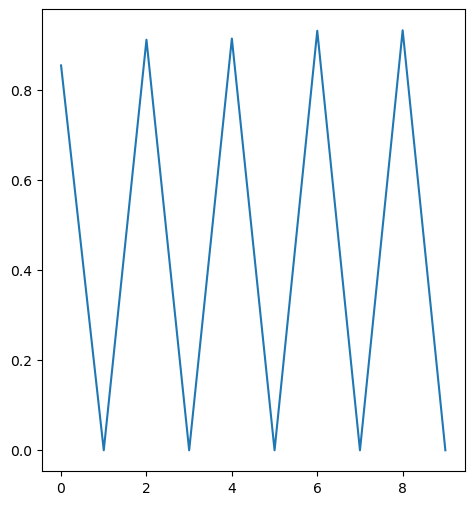

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

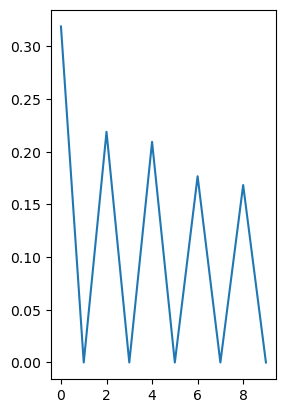

In [19]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
import random
train_dir = os.path.join(extracted_dir, 'train')
test_dir = os.path.join(extracted_dir, 'test')

# Create test directory and subdirectories if they don't exist
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
for class_name in ['landslide', 'non_landslide']:
    class_train_dir = os.path.join(train_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(class_test_dir):
        os.makedirs(class_test_dir)
    
    # Move 20% of the images to the test directory
    images = os.listdir(class_train_dir)
    num_test_images = int(0.2 * len(images))
    test_images = random.sample(images, num_test_images)
    
    for image_name in test_images:
        src_path = os.path.join(class_train_dir, image_name)
        dst_path = os.path.join(class_test_dir, image_name)
        shutil.move(src_path, dst_path)

print("Test dataset created successfully.")

Test dataset created successfully.


In [24]:
# Define the path to your test data directory
test_dir = os.path.join(extracted_dir, 'test')

# Initialize ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

# Set up the test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',    # Ensure binary classification mode
    shuffle=False           # Do not shuffle for evaluation
)


Found 2238 images belonging to 2 classes.


In [25]:
# Step 6: Evaluate the Model on Test Data
test_loss, test_accuracy = landslide_model_DenseNet.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}, Test loss: {test_loss:.2f}')

70/70 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9956 - loss: 0.0270
Test accuracy: 0.99, Test loss: 0.03


In [26]:
# Step 7: Single Image Prediction Helper Functions

# Prediction helper function
def predict_landslide_image(image_path, model):
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = predictions[0][0]

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format("landslide" if score > 0.5 else "non-landslide", 100 * score if score > 0.5 else 100 * (1 - score))
    )

In [27]:
# Resize and display helper function
def resize_show(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Testing with sample images
sample_landslide_img = landslide_img_one_path
sample_non_landslide_img = landslide_img_two_path

Landslide Image Prediction:


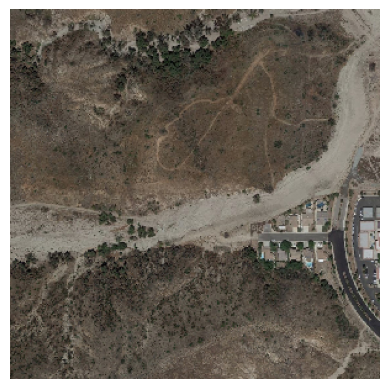

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image most likely belongs to non-landslide with a 100.00 percent confidence.


In [28]:
# Display and Predict for Landslide Image
print("Landslide Image Prediction:")
resize_show(sample_landslide_img)
predict_landslide_image(sample_landslide_img, landslide_model_DenseNet)

Non-Landslide Image Prediction:


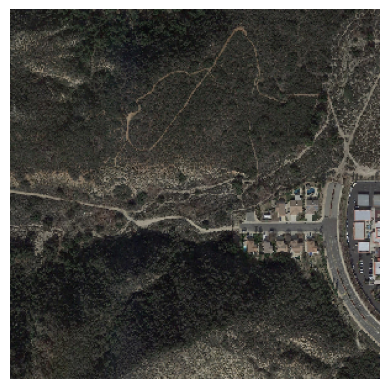

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
This image most likely belongs to non-landslide with a 100.00 percent confidence.


In [29]:
# Display and Predict for Non-Landslide Image
print("Non-Landslide Image Prediction:")
resize_show(sample_non_landslide_img)
predict_landslide_image(sample_non_landslide_img, landslide_model_DenseNet)